In [1]:
using PGFPlots
import HDF5, JLD
using EncounterSimulation
using EncounterModel
using EncounterVisualization
using PyPlot
using EncounterFeatures
using EncounterPolicies

INFO: Loading help data...


In [2]:
trlzero = JLD.load("../data/trlzero_lagrange_sweep_Mar-22_1930.jld")
trl = JLD.load("../data/trlcons_lagrange_sweep_Mar-22_2245.jld")
turning = JLD.load("../data/turning_lagrange_sweep_Mar-22_1957.jld")
turning["risk_ratios"] = turning["risk_ratios"][2:end]
turning["deviations"] = turning["deviations"][2:end]
trlstatic = JLD.load("../data/D_sweep_Mar-23_0005.jld")
curve_data = [
              "Direct control"=>turning,
              "Static TRL"=>trlstatic,
              # "Bounded Static TRL"=>trlstatic2,
              "Optimized TRL"=>trl,
              # "Optimized TRL with D=0 action"=>trlzero,
]
nothing

In [3]:
policy = trl["policies"][2]

LinearPostDecisionPolicy(FeatureBlock({FeatureFunction(:f_in_goal),FeatureFunction(:f_goal_dist),FeatureFunction(:f_one),FeatureFunction(:f_has_deviated),ParameterizedFeatureFunction(:f_symmetric_goal_grid,RectangleGrid with 80 points,true,80),ParameterizedFeatureFunction(:f_focused_intruder_grid,RectangleGrid with 1728 points,true,1728),FeatureFunction(:f_conflict)},true),EncounterAction[HeadingHRL(152.4),HeadingHRL(228.60000000000002),HeadingHRL(304.8),HeadingHRL(457.20000000000005),HeadingHRL(609.6)],[45.8006,-0.106211,-35.8319,98.1681,48.5909,44.4625,40.6528,40.0815,39.5283,43.3344  …  -0.118149,0.388084,1.67001,1.6721,-0.864332,0.840335,1.13483,-0.438365,1.52067,-211.791],DeviationAndTimeReward(100.0,1.0,100.0,251.18864315095823))

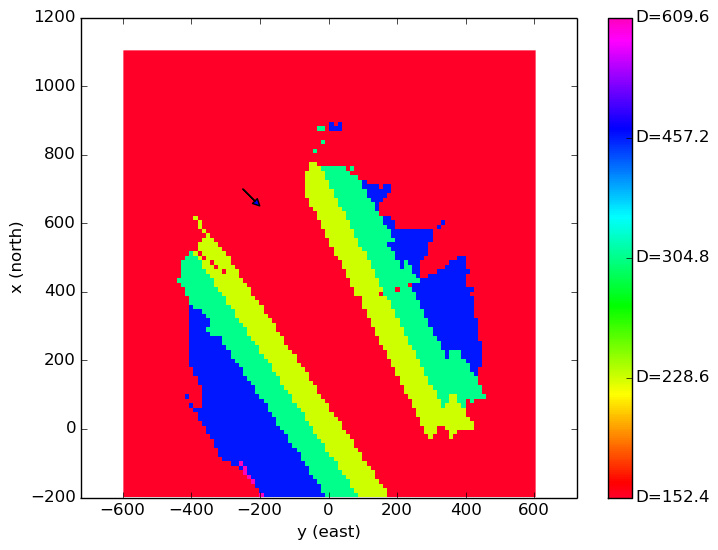

In [9]:
n=100
ownship_heading = 0.0
is = [700.0,-250.0,pi*135/180]
has_deviated=false
ymin = -600.0
ymax = 600.0
xmin = -200.0
xmax = 1100.0
extent=(ymin,ymax,xmin,xmax)
xpoints = linspace(xmin, xmax, n)
ypoints = linspace(ymin, ymax, n)
vals = Array(Float64, n, n)
any_negligible = false
for i in 1:n
    for j in 1:n
        state = EncounterState([xpoints[i], ypoints[j], ownship_heading], is, false, has_deviated)
        if typeof(policy)==LinearQValuePolicy
            qs=Array(Float64, length(policy.actions))
            for k in 1:length(qs)
                qs[k] = sum(evaluate(policy.phi, state)'*policy.thetas[k])
            end
            if maximum(qs) - minimum(qs) <= threshold
                vals[i,j] = 1
                any_negligible = true
            else
                vals[i,j] = indmax(qs) +1
            end
        else
            vals[i,j] = query_policy_ind(policy, state)+1
        end
        # vals[i,j] = maximum(qs)-minimum(qs)
    end
end
# @show vals
clf()
# axis("equal")
imshow(vals, origin="lower", extent=extent, interpolation="nearest", cmap=PyPlot.cm["gist_rainbow"])
xlabel("y (east)")
ylabel("x (north)")
# colorbar()
if length(unique(vals)) > 1
    cbar = colorbar(ticks=[1:length(policy.actions)+1])
    if any_negligible
        cbar[:ax][:set_yticklabels](["Negligible Difference", [string(a) for a in policy.actions]])
    else
        cbar[:ax][:set_yticklabels](["D=$(round(a.D_buffered,1))" for a in policy.actions])
    end
end
ax=gca()
idx = 50*cos(is[3])
idy = 50*sin(is[3])
ax[:arrow](is[2], is[1], idy, idx, head_width=20, head_length=20)
ylim(-100,1000)
axis("equal")
# odx = 50*cos(ownship_heading)
# ody = 50*sin(ownship_heading)
# ax[:arrow](0,0, ody,odx, head_width=20, head_length=20)
savefig("/home/zach/Devel/CDC_Paper/figures/policy.pdf")

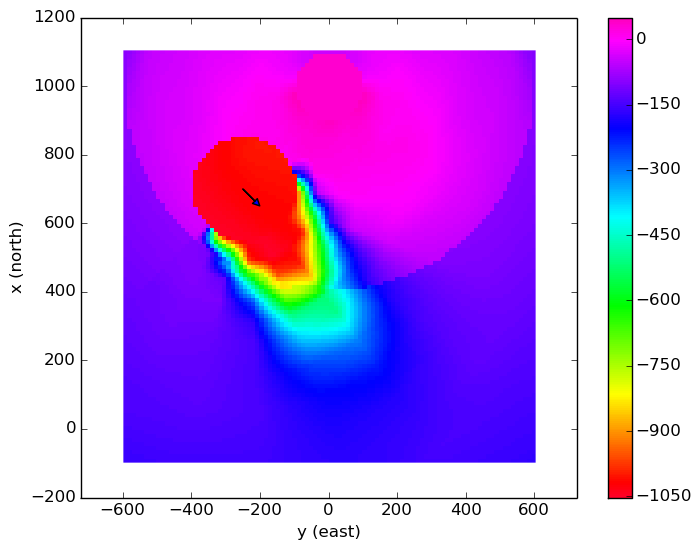

In [6]:
oad=0
data = JLD.load("../data/cdc_val_fig_Mar-23_1713.value")

phi = data["phi"]

oad = 0.0
iad = 135.0
ix = 700.0
iy = -250.0
EncounterVisualization.plot_value_grid(phi,
                                       data["theta"],
                                       [ix, iy, pi/180.0*iad],
                                       pi/180.0*oad,
                                       100,
                                       ownship_arrow=false)
axis("equal")
savefig("/home/zach/Devel/CDC_Paper/figures/value.pdf")

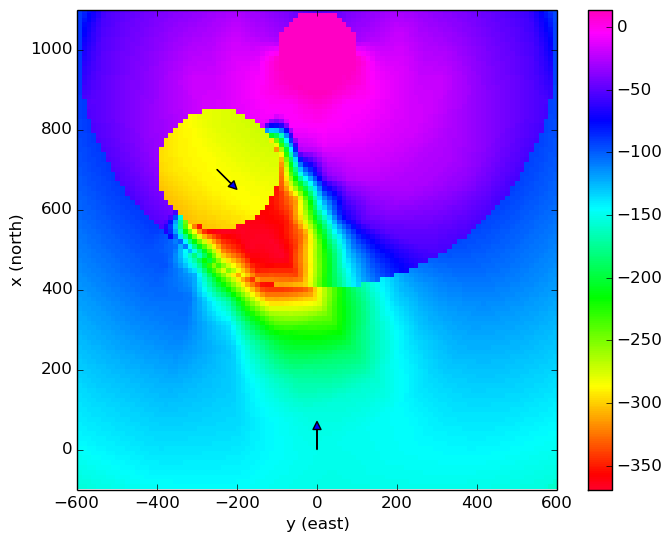

PyObject <matplotlib.patches.FancyArrow object at 0x7fb03a6a8e50>

In [44]:
oad=0
EncounterVisualization.plot_value_grid(policy.phi,policy.theta,is,pi/180.0*oad,deviated=false)

# this is a post-decision value function

In [47]:
using EncounterFeatures
FEATURES

FeatureBlock({FeatureFunction(:f_in_goal),FeatureFunction(:f_goal_dist),FeatureFunction(:f_one),FeatureFunction(:f_has_deviated),ParameterizedFeatureFunction(:f_symmetric_goal_grid,RectangleGrid with 80 points,true,80),ParameterizedFeatureFunction(:f_focused_intruder_grid,RectangleGrid with 1728 points,true,1728),FeatureFunction(:f_conflict)},true)

In [19]:
approach = trlcons
for i in 1:length(approach["policies"])
    @show approach["lambdas"][i]
    @show approach["policies"][i].theta[4]
end

(approach["lambdas"])[i] => 100.0
(approach["policies"])[i].theta[4] => 98.48523468884358
(approach["lambdas"])[i] => 398.1071705534973
(approach["policies"])[i].theta[4] => 98.62710769516217
(approach["lambdas"])[i] => 1584.893192461114
(approach["policies"])[i].theta[4] => 99.07803553605291
(approach["lambdas"])[i] => 6309.57344480193
(approach["policies"])[i].theta[4] => 100.63289826330525
(approach["lambdas"])[i] => 25118.864315095823
(approach["policies"])[i].theta[4] => 106.63296503106183
(approach["lambdas"])[i] => 100000.0
(approach["policies"])[i].theta[4] => 130.49681643277165


In [11]:
trl["lambdas"][3]

138.94954943731375

In [12]:
data = JLD.load("../data/box_10k_collisions.ic")
ics = data["ics"]
seeds = data["seeds"]
nothing

policy: 32
baseline: 32


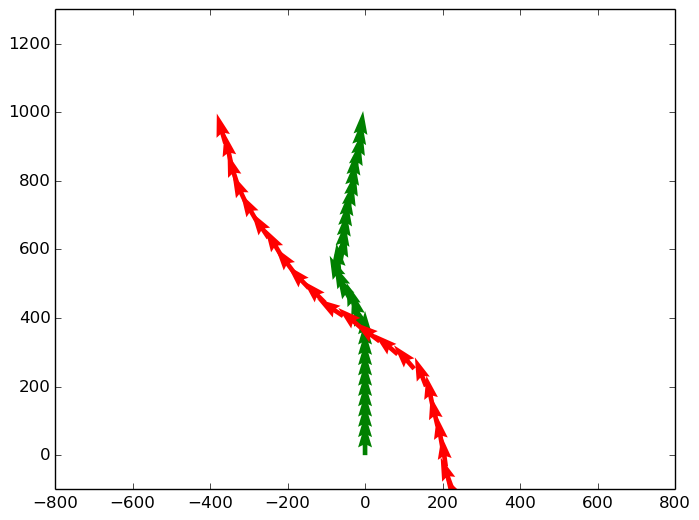

(-100,1300)

In [13]:
j=8
test = EncounterTest(EncounterTestInputData(ics[j],seed=seeds[j],policy=policy))
run!(test)
ctest = EncounterTest(EncounterTestInputData(ics[j],seed=seeds[j],policy=ConstPolicy(HeadingHRL(100.0))))
run!(ctest)
println("policy: $(test.output.steps_before_end)")
println("baseline: $(ctest.output.steps_before_end)")
ax=gca()
for s in test.output.states
    if !s.end_state
        EncounterVisualization.vehicle_arrow(ax,s.os,color="g")
        EncounterVisualization.vehicle_arrow(ax,s.is,color="r")
    end
end
xlim(-800,800)
ylim(-100,1300)
# axis("equal")